In [1]:
import os

import pandas as pd
from pandas.api.types import is_string_dtype as ist
from pandas.api import types

import numpy as np
import torch
import networkx as nx

import itertools
import time
import warnings
import random
import re

from scipy import stats
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from scipy import stats
from scipy.stats.contingency import expected_freq
from scipy.spatial import distance
from scipy.signal import convolve2d
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModel

warnings.filterwarnings("ignore")
%matplotlib inline

D:\DEV\Anaconda3\envs\phddiscovery\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filenames = {}

def extract(filename):
    return pd.read_csv(filename, sep='\t')

def read_files(directory, max_kb):
    dfs = {}
    i = 0
    for filename in os.listdir(directory):
        i = i+1
        size = os.stat(f'{directory}\\{filename}').st_size
        if max_kb == 0 or size <= max_kb:
            f = os.path.join(directory, filename)
            if os.path.isfile(f):
                new_f = str(i).zfill(5)
                filenames[new_f] = filename
                dfs[new_f]= extract(f)
    return dfs

In [3]:
dfs = read_files('data\\edu', 0)
len(dfs)

201

In [4]:
list(dfs.values())[0]

,level_4_2,level_1_1,year,level_1_2,level_2_1,level_2_2,level_3_1,level_3_2,level_4_1,level_3_4_2,number_tested,mean_scale_score,level_3_4_1,grade,category
0,0.2,7261,2013,65.3,3100,27.9,742,6.7,20.0,6.9,11123,276,762,3,ELL
1,0.2,6443,2014,69.7,2143,23.2,636,6.9,19.0,7.1,9241,270,655,3,ELL
2,0.6,6505,2015,68.1,2293,24.0,708,7.4,53.0,8.0,9559,272,761,3,ELL
3,0.4,6441,2013,68.3,2644,28.0,305,3.2,39.0,3.6,9429,267,344,4,ELL
4,0.7,6505,2014,66.6,2688,27.5,506,5.2,69.0,5.9,9768,270,575,4,ELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,0.8,8720,2014,65.3,3877,29.0,650,4.9,103.0,5.6,13350,267,753,8,SWD
227,0.8,8317,2015,62.4,4123,30.9,782,5.9,100.0,6.6,13322,269,882,8,SWD
228,0.8,55461,2013,70.2,19078,24.1,3828,4.8,668.0,5.7,79035,267,4496,All Grades,SWD
229,1.1,58149,2014,67.6,22093,25.7,4780,5.6,956.0,6.7,85978,268,5736,All Grades,SWD


In [14]:
dfs_new = {}
for key, df in dfs.items():
    s = len(df.columns)
    #print(s)
    if s >= 5:
        dfs_new[key]=df
len(dfs_new)

190

In [15]:
list(dfs_new.values())[10]

,year,num_level_1,num_level_3,demographic,number_tested,num_level_2,pct_level_3_and_4,mean_scale_score,dbn,num_level_4,pct_level_4,pct_level_3,pct_level_2,grade,pct_level_1,num_level_3_and_4
0,2006,2,20,All Students,39,11,66.7,667,01M015,6,15.4,51.3,28.2,3,5.1,26
1,2007,2,22,All Students,31,3,83.9,672,01M015,4,12.9,71,9.7,3,6.5,26
2,2008,0,29,All Students,37,6,83.8,668,01M015,2,5.4,78.4,16.2,3,0,31
3,2009,0,28,All Students,33,4,87.9,668,01M015,1,3,84.8,12.1,3,0,29
4,2010,6,6,All Students,26,12,30.8,677,01M015,2,7.7,23.1,46.2,3,23.1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33456,2008,139,26,All Students,211,46,12.3,NaN,75X723,0,0,12.3,21.8,All Grades,65.9,26
33457,2009,88,30,All Students,209,87,16.3,NaN,75X723,4,1.9,14.4,41.6,All Grades,42.1,34
33458,2010,157,10,All Students,242,75,4.1,NaN,75X723,0,0,4.1,31,All Grades,64.9,10
33459,2011,153,8,All Students,229,67,3.9,617,75X723,1,0.4,3.5,29.3,All Grades,66.8,9


In [16]:
def remove_s(adf):
    for col in adf:
        m = adf.loc[adf[col] != 's']
        m = m[col].mode()[0]
        adf[col].replace('s', m, inplace=True)
        
def conver_percent(adf):
    return adf.apply(lambda x: x.str.rstrip("%").astype(float)/100 if ist(x) and x.str.match(pat='%$').any() else x)

def fill_na(adf):
    for col in adf:
        if types.is_numeric_dtype(adf[col].dtypes):
            skew = stats.skew(adf[col])
            normal = True if -0.5 > skew or skew < 0.5 else False
            if normal:
                mean = adf[col].mean()
                adf[col].fillna(int(mean), inplace=True)            
            else:
                median = adf[col].median()
                adf[col].fillna(median, inplace=True)
        else:
            mode = adf[col].mode()
            adf[col].fillna(mode, inplace=True)

In [17]:
for key, df in dfs_new.items():
    df.replace('-', np.nan, inplace=True) #replace all '-' values with NaN
    df.dropna(how="all", axis=1, inplace=True) #drop columns where all values are NaN
    remove_s(df) #replace column values of 's' with mode()
    df = conver_percent(df) #convert string percent
    fill_na(df)
    dfs_new[key] = df

In [77]:
dfs_new[list(dfs_new)[3]]

,site_name,program_type,location_1/latitude,location_1/human_address/address,location_1/human_address/city,location_1/human_address/zip,location_1/longitude,agency,borough_community,program,grade_level_age_group,contact_number
0,PS 11,After-School Programs,40.839271,1257 Ogden Avenue,P,10452.0,-73.925788,Alianza Dominicana Inc.,Bronx,Beacon,6 and up,718.590.0101
1,JHS 349/345,After-School Programs,40.810049,345 Brook Avenue,NaN,10454.0,-73.917823,Aspira of New York,Bronx,Beacon,6 and up,718.842.8289
2,MS 117,After-School Programs,40.848548,1865 Morris Avenue,NaN,10453.0,-73.908435,Community Association Progressive Dominicans,Bronx,Beacon,6 and up,718.466.1806
3,Dr. Charles R. Drew Educational Complex,After-School Programs,40.833637,3630 3rd Avenue,NaN,10456.0,-73.904406,Directions for Our Youth,Bronx,Beacon,6 and up,718.293.4344
4,MS 45,After-School Programs,40.890810,2502 Lorillard Place,NaN,10466.0,-73.846009,Good Shepherd Services,Bronx,Beacon,6 and up,718.367.9577
...,...,...,...,...,...,...,...,...,...,...,...,...
75,MS 210,After-School Programs,40.684578,93 11 101st Avenue,NaN,11416.0,-73.849602,YMCA Cross Island,Queens,Beacon,6 and up,718.659.7710
76,IS 49,After-School Programs,40.720707,977 Fox Street,NaN,11207.0,-73.920994,Jewish Community Center of Staten Island,Staten Island,Beacon,6 and up,718.556.1565
77,Tottenville HS,After-School Programs,40.528262,100 Luten Avenue,NaN,10312.0,-74.192177,Jewish Community Center of Staten Island,Staten Island,Beacon,6 and up,718.605.3033
78,IS 2,After-School Programs,40.576712,333 Midland Avenue,NaN,10306.0,-74.100627,United Activities Unlimited,Staten Island,Beacon,6 and up,718.987.0351


In [78]:
dfs_new2 = dict(itertools.islice(dfs_new.items(), 50))
#dfs_new2 = dfs_new.copy()
len(list(dfs_new2))

50

In [79]:
dfs_new2.keys()

dict_keys(['00001', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050', '00051', '00052'])

In [20]:
qual_data = {}
quan_data = {}
def separate(dfs, qual_data, quan_data):
    for t_name, df in dfs.items():    
        for (idx, col) in enumerate(df):
            #print(f'idx[{idx}],col[{col}]')
            if not types.is_numeric_dtype(df[col].dtypes):
                if not t_name in qual_data:
                    qual_data[t_name] = []
                qual_data[t_name].append(col)
            else:
                if not t_name in quan_data:
                    quan_data[t_name] = []
                quan_data[t_name].append(col)

separate(dfs_new2, qual_data, quan_data)

In [21]:
class Node:
    def __init__(self, t_name):
        self.t_name = t_name
        self.similarities = {}
    
    def score_add(self, to_name, score):
        if self.similarities.get(to_name):
            prev_score = self.similarities.get(to_name)
            score = (prev_score + score)/2
        self.similarities[to_name] = score

def compare(data, dfs, res, quan=0):
    def compareit(res, t_name1, col1, t_name2, col2):
        df1 = dfs[t_name1]
        x = df1[col1]
        df2 = dfs[t_name2]        
        y = df2[col2]
        s = len(x) if len(x) < len(y) else len(y)
        
        src_node = res.get(t_name1)
        dst_node = res.get(t_name2)
        if not src_node:
            src_node = Node(t_name1)
            res[t_name1] = src_node
        if not dst_node:
            dst_node = Node(t_name2)
            res[t_name2] = dst_node
        
        if quan==0:
            contingency = pd.crosstab(x[:s], y[:s])
            cs = np.sum(contingency)
            valid = all(v > 0 for v in cs)
            if (valid):
                c, p, dof, expected = stats.chi2_contingency(contingency)
                if p is not np.nan and p is not np.inf:
                    src_node.score_add(t_name2, p)
                    dst_node.score_add(t_name1, p)
        else:
            p = distance.jensenshannon(x[:s], y[:s], axis=0)
            if p is not np.nan and p is not np.inf and p < 0.1:
                src_node.score_add(t_name2, p)
                dst_node.score_add(t_name1, p)

    for i, t_name1 in enumerate(data):
        for j, t_name2 in enumerate(data):
            if i==j:
                continue
            elif i<j:                
                [compareit(res, t_name1, col1, t_name2, col2) for i, col1 in enumerate(data[t_name1]) for j, col2 in enumerate(data[t_name2])]

In [22]:
start_time = time.time()

res = {}
compare(qual_data, dfs_new2, res)
compare(quan_data, dfs_new2, res, quan=1)

elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 01:16:45


In [69]:
coords = {}
for t_name, df in dfs_new2.items():
    x=y=0
    for (idx, col) in enumerate(df):
        if not types.is_numeric_dtype(df[col].dtypes):
            x=x+1
        else:
            y=y+1
    coords[t_name]=[x,y]
x = [val[0] for i, val in enumerate(coords.values())]
y = [val[1] for i, val in enumerate(coords.values())]
label = [val for i, val in enumerate(coords.keys())]

fig = go.Figure(data=go.Scatter(x=label,
                                y=[(i/(1 if j is 0 else j)) for i,j in zip(x, y)],
                                mode='markers',
                                marker_color='blue',
                                text=random.sample(range(1, 51), 50)))

fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title='The distribution of the ratio of Categorical vs Numerical attrs.')
fig.show()

In [24]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=label,
    y=x,
    name='Categorical Fields',
    marker_color='DarkSlateGrey'
))
fig.add_trace(go.Bar(
    x=label,
    y=y,
    name='Numerical Fields',
    marker_color='MediumPurple'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title='The distribution of the total number of Categorical vs Numerical attrs.')
fig.show()

In [25]:
def get_col_names(df):
    cols = []
    new_sp = []
    for col in df.columns:
        col = re.sub('[^a-zA-Z]', ' ', col).strip()
        sp = col.split(' ')
        for s in sp:
            s = s.strip()
            if s not in new_sp and len(s)>2:
                new_sp.append(s.strip())
                
    cols.append(' '.join(new_sp))    
    return cols

columns = {}
for key, df in dfs_new2.items():
    columns[key] = get_col_names(df)

In [26]:
col_values = []
for _, vals in columns.items():
    col_values.append(' '.join(vals))

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

# initialize dictionary that will contain tokenized sentences
tokens = {'input_ids': [], 'attention_mask': []}

for sentence in col_values:
    # tokenize sentence and append to dictionary lists
    new_tokens = tokenizer.encode_plus(sentence, max_length=128, truncation=True,
                                       padding='max_length', return_tensors='pt')
    tokens['input_ids'].append(new_tokens['input_ids'][0])
    tokens['attention_mask'].append(new_tokens['attention_mask'][0])

# reformat list of tensors into single tensor
tokens['input_ids'] = torch.stack(tokens['input_ids'])
tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

In [27]:
outputs = model(**tokens)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [28]:
embeddings = outputs.last_hidden_state
print(embeddings.shape)
attention_mask = tokens['attention_mask']
print(attention_mask.shape)
mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
print(mask.shape)
masked_embeddings = embeddings * mask
print(masked_embeddings.shape)
summed = torch.sum(masked_embeddings, 1)
print(summed.shape)
summed_mask = torch.clamp(mask.sum(1), min=1e-9)
print(summed_mask.shape)

torch.Size([50, 128, 768])
torch.Size([50, 128])
torch.Size([50, 128, 768])
torch.Size([50, 128, 768])
torch.Size([50, 768])
torch.Size([50, 768])


In [29]:
mean_pooled = summed / summed_mask

# convert from PyTorch tensor to numpy array
mean_pooled = mean_pooled.detach().numpy()

def get_similarity(idx):    
    #print(idx)
    # calculate
    sim = cosine_similarity(
        [mean_pooled[idx]],
        mean_pooled[:]
    )
    return sim[0]

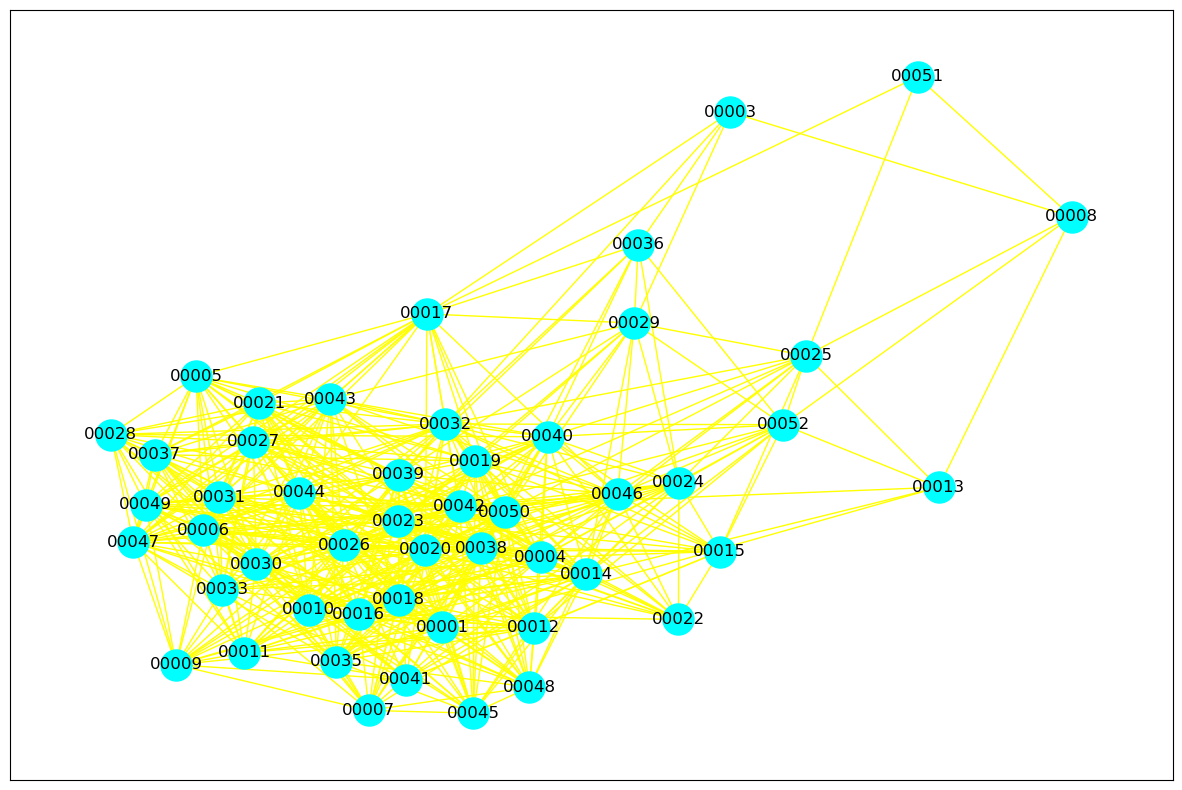

In [80]:
G=nx.Graph()
w_s1 = 0.6
w_s2 = 0.4
beta = 0.5
alpha = 0.05

l_res = list(res)

for k1, v1 in res.items():
    G.add_node(k1)
    sim = get_similarity(l_res.index(k1))
    for k2, v2 in v1.similarities.items():
        #print(f'{k1}__{k2}={v2}\n')
        G.add_node(k2)
        sim_score = sim[l_res.index(k2)]
        if sim_score < beta:
            sim_score = 0
        if v2 >= 0 and v2 <= alpha:
            v2 = (alpha-v2)/alpha
        avg = (w_s1*sim_score + w_s2*v2)
        #print(f'sim[{sim_score}],v2[{v2}],avg[{avg}]')
        if avg >= beta:
            score = w_s1*sim_score + w_s2*v2
            G.add_edge(k1,k2)
            G[k1][k2]['similarity']=score
        
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
nx.draw_networkx(G, ax=ax, edge_color='yellow', node_color='cyan', 
                 with_labels=True, nodelist=G.nodes(), node_size=500)

In [81]:
A=nx.adjacency_matrix(G) #adjacency matrix
L = csgraph.laplacian(A, normed=True)
w,v = eigsh(L, which='SM')

In [82]:
def computeclusters(no_clusters, X):
    kmeans = cluster.KMeans(init='k-means++', n_clusters=no_clusters, n_init=20)
    #kmeans = cluster.SpectralClustering(4, affinity='precomputed', n_init=10, assign_labels='discretize')
    #kmeans = cluster.DBSCAN(eps=3, min_samples=2).fit(X)
    kmeans.fit_predict(X)

    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    error = kmeans.inertia_
    #print(labels)

    return X, labels, error

def drawclusters(no_clusters, X, show_label=True): 
    X, labels, _ = computeclusters(no_clusters, X)
    
    get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
    colors = get_colors(no_clusters)

    node_colors = [colors[i] for i in labels]

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    nx.draw_networkx(G, ax=ax, edge_color='yellow', node_color=node_colors, with_labels=True, 
                     nodelist=G.nodes(), node_size=500)
    #nx.draw(G, edge_color='yellow', node_color=node_colors, with_labels=show_label)
    return X, labels, node_colors

error:[0.07410125181615759], silhouette_score:[0.38560550843345065], best-of-clusters:[12]


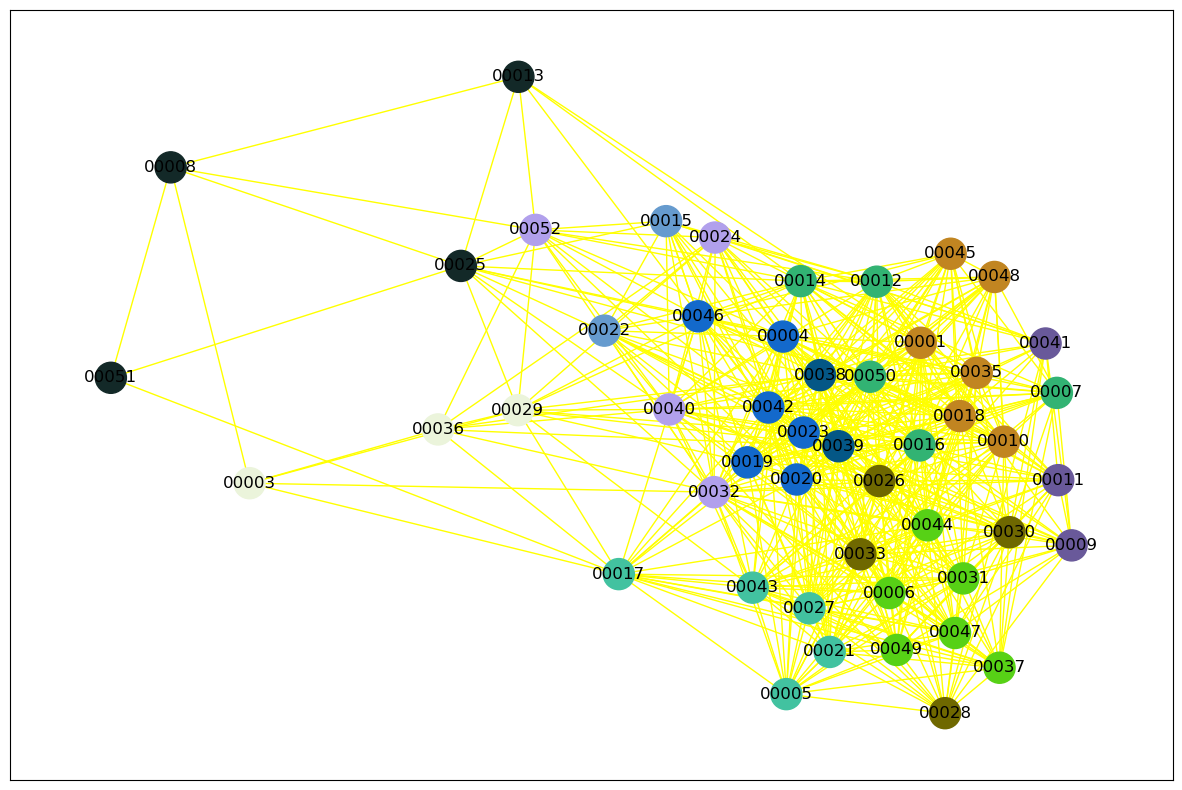

In [84]:
epoch = int(len(G.nodes())/2)
X = v*w

prev_sscore = -np.inf
best_clusters = 2
inertias = []
K = range(1, epoch)
for k in K:
    no_clusters = 2+k
    X, labels, error = computeclusters(no_clusters, X)
    #print(f'error:[{error}], silhouette_score:[{prev_sscore}], best-of-clusters:[{best_clusters}]')
    inertias.append(error)
    sscore = silhouette_score(X, labels)
    if prev_sscore < sscore:
        prev_sscore = sscore
        best_clusters = no_clusters
        
print(f'error:[{error}], silhouette_score:[{prev_sscore}], best-of-clusters:[{best_clusters}]')
X, labels, node_colors = drawclusters(best_clusters, X)

In [108]:
ll = list(dfs_new.values())
for i in range(50):
    print(f'idx:[{i}]')
    print(ll[i].columns)

idx:[0]
Index(['level_4_2', 'level_1_1', 'year', 'level_1_2', 'level_2_1', 'level_2_2',
       'level_3_1', 'level_3_2', 'level_4_1', 'level_3_4_2', 'number_tested',
       'mean_scale_score', 'level_3_4_1', 'grade', 'category'],
      dtype='object')
idx:[1]
Index(['black_2', 'black_1', 'total_enrollment', 'year', 'male_2', 'grade_10',
       'hispanic_2', 'qualified_for_free_or_reduced_lunches_2',
       'qualified_for_free_or_reduced_lunches_1', 'hispanic_1', 'grade_11',
       'grade_12', 'grade_8', 'white_1', 'grade_9', 'white_2', 'female_2',
       'school_name', 'female_1', 'other_2', 'other_1', 'dbn', 'grade_k',
       'grade_pk', 'male_1', 'students_with_disabilities_1',
       'students_with_disabilities_2', 'asian_2', 'grade_1', 'asian_1',
       'grade_2', 'grade_3', 'grade_4', 'grade_5', 'grade_6',
       'english_language_learners_1', 'grade_7', 'english_language_learners_2',
       'poverty', 'poverty_2'],
      dtype='object')
idx:[2]
Index(['project_type_', 'total_phas

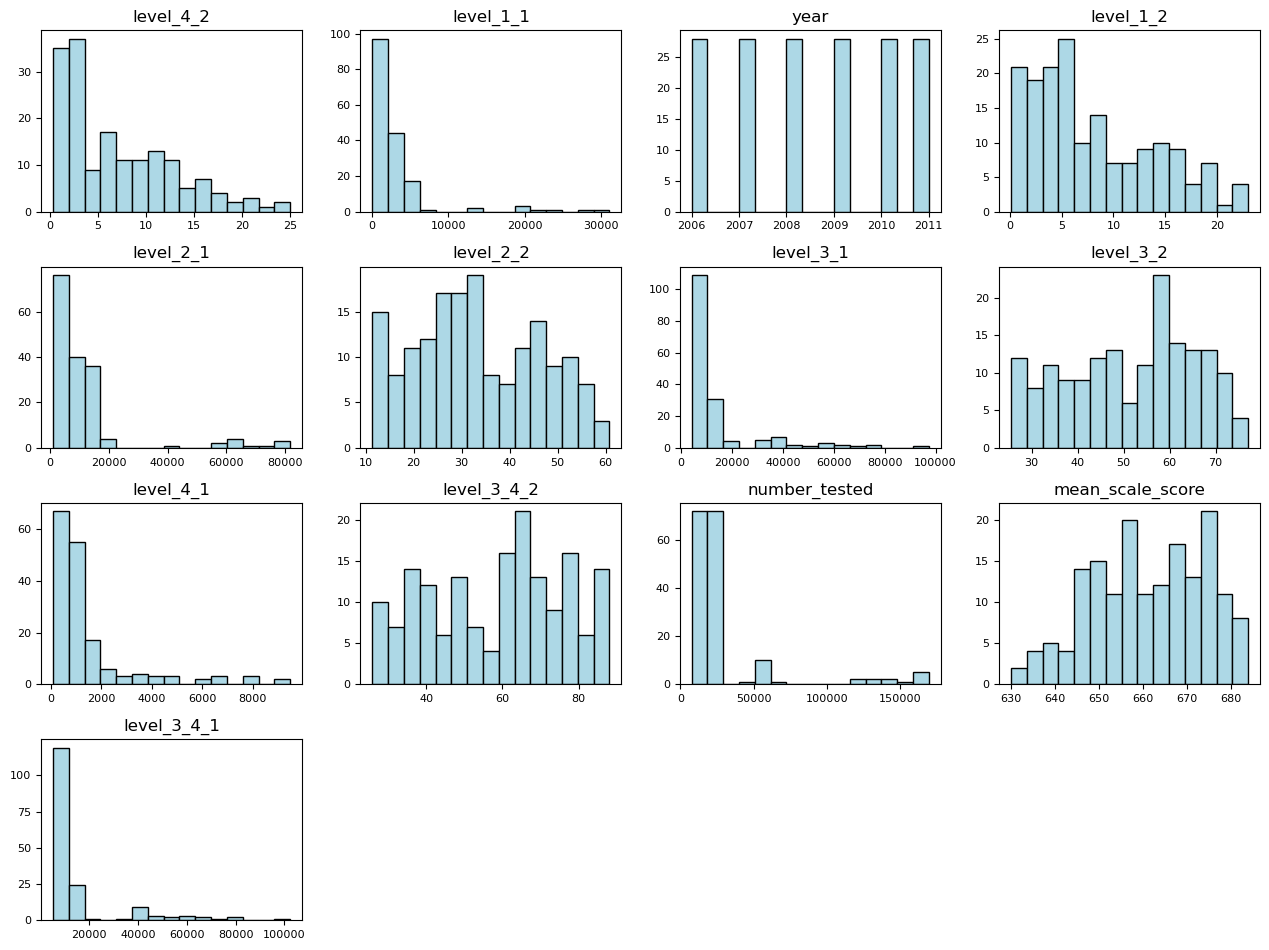

In [103]:
data = list(dfs.values())[9]
data.hist(bins=15, color='lightblue', edgecolor='black', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 2, 2))   

In [34]:
print(filenames.get('00001'))
print(filenames.get('00019'))

26kp-bgdh.tsv
4n2j-ut8i.tsv


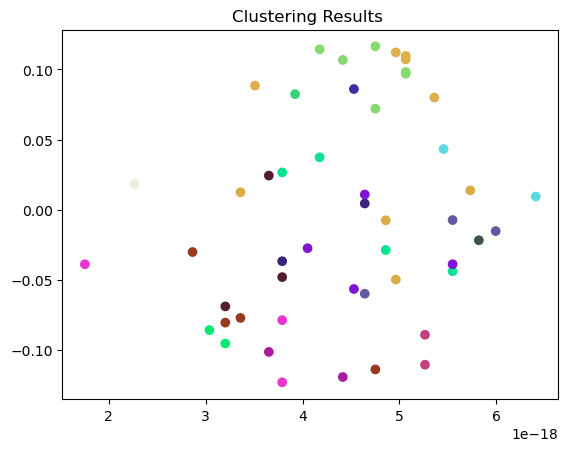

In [35]:
plt.title(f'Clustering Results ')
plt.scatter(X[:,0], X[:,1], c=node_colors)
#print(X[:,3])
#print(X[:,1])
#sns.scatterplot(X[:,0],X[:,1])
#X

Silhouette Score(n=7): 0.3193574468516463


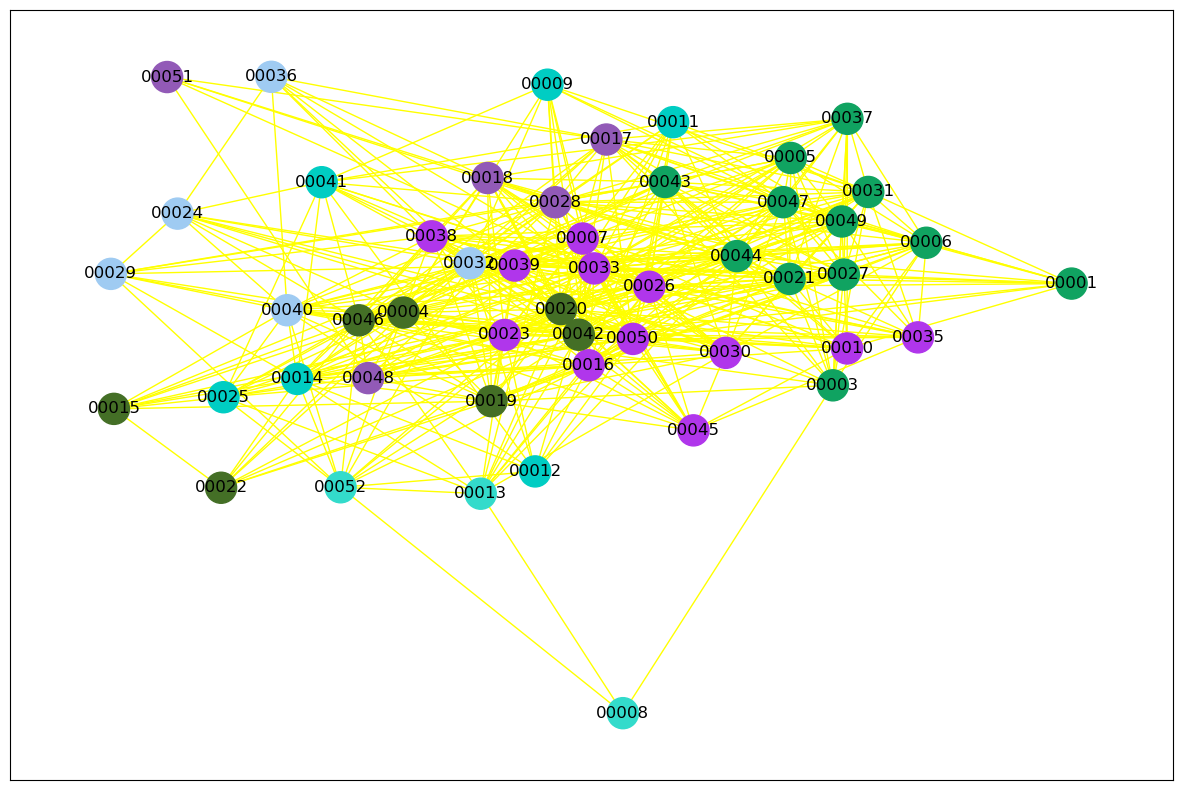

In [36]:
no_clusters = 7
X, labels, _ = drawclusters(no_clusters, X)
print(f'Silhouette Score(n={no_clusters}): {silhouette_score(X, labels)}')

In [37]:
print(filenames.get('00005'))
print(filenames.get('00037'))
print(filenames.get('00040'))

35sw-rdxj.tsv
8586-3zfm.tsv
8a4n-zmpj.tsv


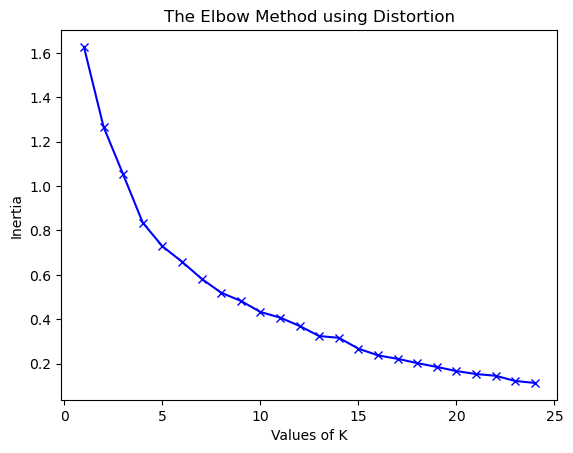

In [38]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Distortion')
plt.show()

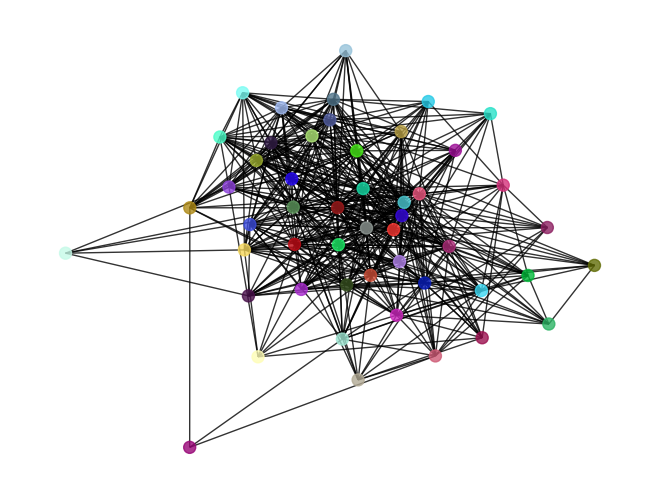

In [39]:
from community import community_louvain
#comms = community_louvain.best_partition(G)
comms = community_louvain.best_partition(G, weight='weight')

get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
colors = get_colors(len(comms.values()))
    
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size = 75, alpha = 0.8, node_color=colors)
plt.show()

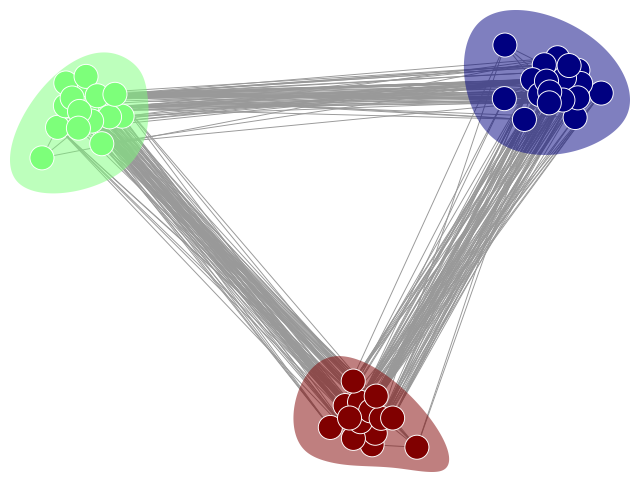

0.10000772307492198


In [40]:
from communities.algorithms import louvain_method, spectral_clustering, girvan_newman, hierarchical_clustering
from communities.visualization import draw_communities
from communities.visualization import louvain_animation
from communities.utilities import modularity_matrix, modularity

adj_matrix = nx.to_numpy_array(G)

communities, _ = louvain_method(adj_matrix)
#communities = spectral_clustering(adj_matrix, k=6)
#communities, _ = girvan_newman(adj_matrix, 7) #take long time..
#communities = hierarchical_clustering(adj_matrix, metric="euclidean", linkage="complete", n=14)


draw_communities(adj_matrix, communities)
#louvain_animation(adj_matrix, frames)

mod_matrix = modularity_matrix(adj_matrix)
Q = modularity(mod_matrix, communities)
print(Q)